# Autoregressions

This notebook introduces autoregression modeling using the `AutoReg` model. It also covers aspects of `ar_select_order` assists in selecting models that minimize an information criteria such as the AIC. 
An autoregressive model has dynamics given by 

$$ y_t = \delta + \phi_1 y_{t-1} + \ldots + \phi_p y_{t-p} + \epsilon_t. $$

`AutoReg` also permits models with:

* Deterministic terms (`trend`)
  * `n`: No deterministic term 
  * `c`: Constant (default)
  * `ct`: Constant and time trend
  * `t`: Time trend only
* Seasonal dummies (`seasonal`)
  * `True` includes $s-1$ dummies where $s$ is the period of the time series (e.g., 12 for monthly)
* Custom deterministic terms (`deterministic`)
  * Accepts a `DeterministicProcess`
* Exogenous variables (`exog`)
  * A `DataFrame` or `array` of exogenous variables to include in the model
* Omission of selected lags (`lags`)
  * If `lags` is an iterable of integers, then only these are included in the model.

The complete specification is

$$ y_t = \delta_0 + \delta_1 t + \phi_1 y_{t-1} + \ldots + \phi_p y_{t-p} + \sum_{i=1}^{s-1} \gamma_i d_i + \sum_{j=1}^{m} \kappa_j x_{t,j} + \epsilon_t. $$

where:

* $d_i$ is a seasonal dummy that is 1 if $mod(t, period) = i$. Period 0 is excluded if the model contains a constant (`c` is in `trend`).
* $t$ is a time trend ($1,2,\ldots$) that starts with 1 in the first observation.
* $x_{t,j}$ are exogenous regressors.  **Note** these are time-aligned to the left-hand-side variable when defining a model.
* $\epsilon_t$ is assumed to be a white noise process.

This first cell imports standard packages and sets plots to appear inline.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

This cell sets the plotting style, registers pandas date converters for matplotlib, and sets the default figure size.

In [2]:
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

The first set of examples uses the month-over-month growth rate in U.S. Housing starts that has not been seasonally adjusted. The seasonality is evident by the regular pattern of peaks and troughs. We set the frequency for the time series to "MS" (month-start) to avoid warnings when using `AutoReg`.

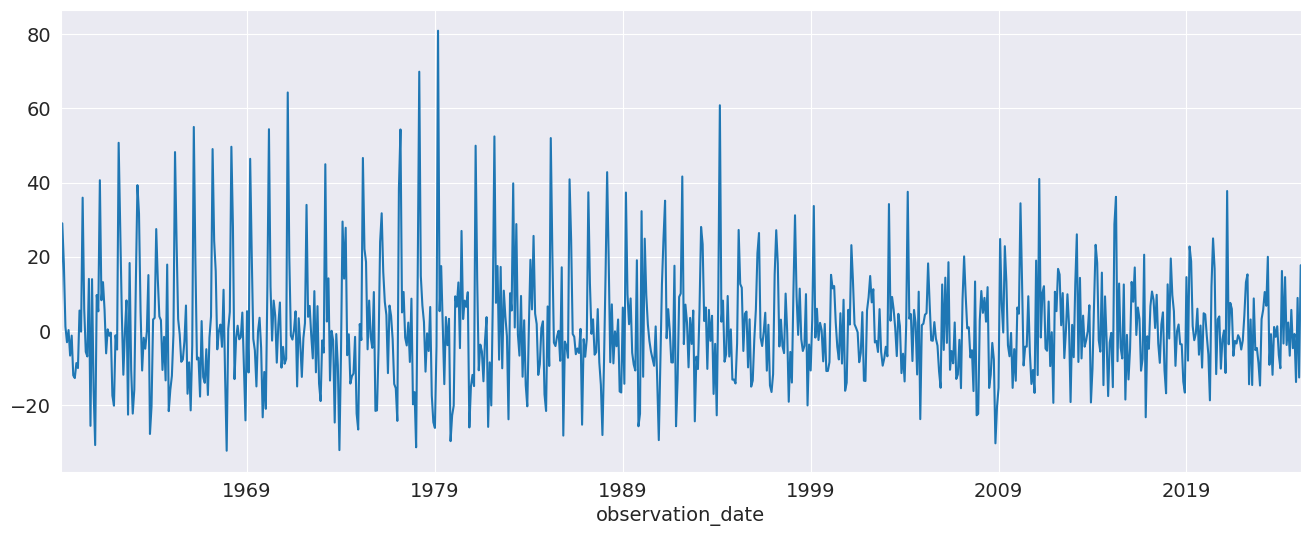

In [3]:
data_loc = "https://raw.githubusercontent.com/statsmodels/smdatasets/refs/heads/main/data/autoregressions/HOUSTNSA.csv"
housing_data = pd.read_csv(
    data_loc,
    index_col=0,
    parse_dates=True,
)
housing = housing_data.HOUSTNSA.pct_change().dropna()
# Scale by 100 to get percentages
housing = 100 * housing.asfreq("MS")
fig, ax = plt.subplots()
ax = housing.plot(ax=ax)

We can start with an AR(3).  While this is not a good model for this data, it demonstrates the basic use of the API.

In [4]:
mod = AutoReg(housing, 3, old_names=False)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  793
Model:                     AutoReg(3)   Log Likelihood               -3256.705
Method:               Conditional MLE   S.D. of innovations             14.932
Date:                Fri, 12 Sep 2025   AIC                           6523.410
Time:                        17:41:56   BIC                           6546.771
Sample:                    05-01-1959   HQIC                          6532.390
                         - 02-01-2025                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0817      0.534      2.024      0.043       0.034       2.129
HOUSTNSA.L1     0.1781      0.035      5.104      0.000       0.110       0.246
HOUSTNSA.L2     0.0131      0.035      0.369    

`AutoReg` supports the same covariance estimators as `OLS`.  Below, we use `cov_type="HC0"`, which is White's covariance estimator. While the parameter estimates are the same, all of the quantities that depend on the standard error change.

In [5]:
res = mod.fit(cov_type="HC0")
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  793
Model:                     AutoReg(3)   Log Likelihood               -3256.705
Method:               Conditional MLE   S.D. of innovations             14.932
Date:                Fri, 12 Sep 2025   AIC                           6523.410
Time:                        17:41:56   BIC                           6546.771
Sample:                    05-01-1959   HQIC                          6532.390
                         - 02-01-2025                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0817      0.560      1.932      0.053      -0.016       2.179
HOUSTNSA.L1     0.1781      0.034      5.275      0.000       0.112       0.244
HOUSTNSA.L2     0.0131      0.037      0.353    

In [6]:
sel = ar_select_order(housing, 13, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  793
Model:                    AutoReg(13)   Log Likelihood               -2939.564
Method:               Conditional MLE   S.D. of innovations             10.483
Date:                Fri, 12 Sep 2025   AIC                           5909.128
Time:                        17:41:56   BIC                           5979.017
Sample:                    03-01-1960   HQIC                          5936.008
                         - 02-01-2025                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.4235      0.441      3.231      0.001       0.560       2.287
HOUSTNSA.L1     -0.2728      0.034     -7.983      0.000      -0.340      -0.206
HOUSTNSA.L2     -0.0799      0.031     -2.61

`plot_predict` visualizes forecasts.  Here we produce a large number of forecasts which show the string seasonality captured by the model.

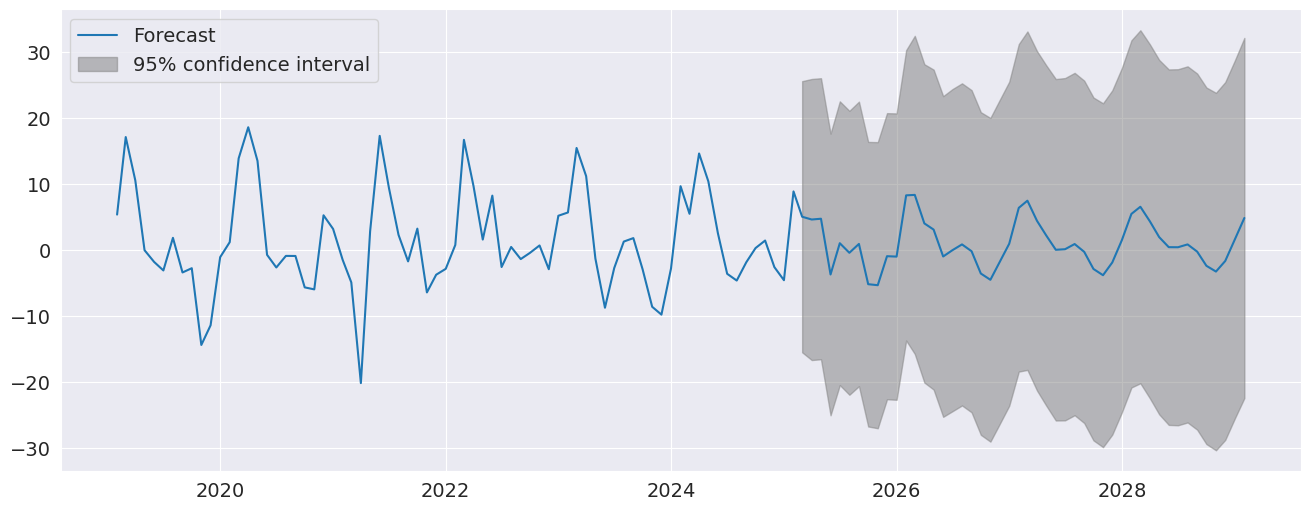

In [7]:
fig = res.plot_predict(720, 840)

`plot_diagnositcs` indicates that the model captures the key features in the data.

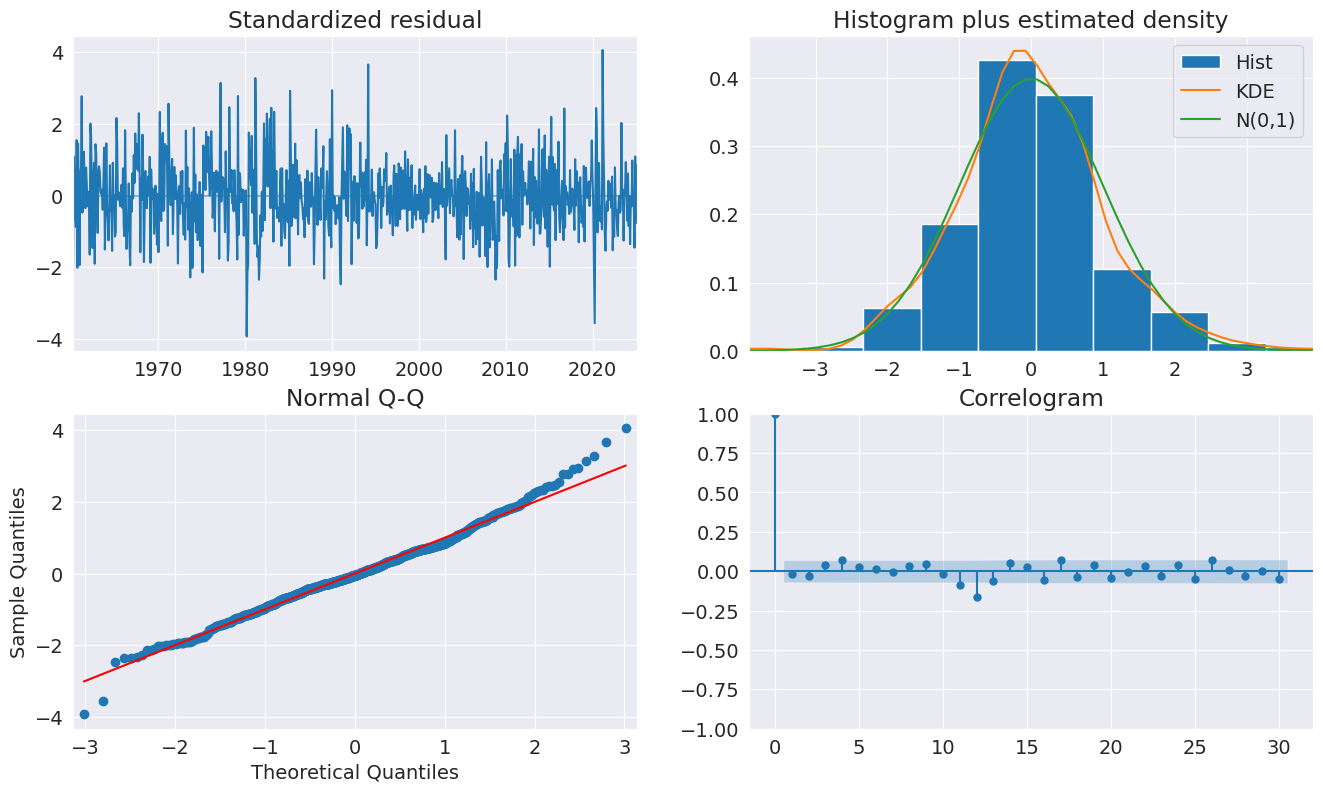

In [8]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

## Seasonal Dummies

`AutoReg` supports seasonal dummies which are an alternative way to model seasonality.  Including the dummies shortens the dynamics to only an AR(2).

In [9]:
sel = ar_select_order(housing, 13, seasonal=True, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  793
Model:               Seas. AutoReg(1)   Log Likelihood               -2936.578
Method:               Conditional MLE   S.D. of innovations              9.864
Date:                Fri, 12 Sep 2025   AIC                           5901.155
Time:                        17:42:00   BIC                           5966.599
Sample:                    03-01-1959   HQIC                          5926.308
                         - 02-01-2025                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.4122      1.223      2.790      0.005       1.015       5.810
s(2,12)        28.8933      1.742     16.589      0.000      25.479      32.307
s(3,12)        16.9396      2.115      8.010    

The seasonal dummies are obvious in the forecasts which has a non-trivial seasonal component in all periods 10 years in to the future.

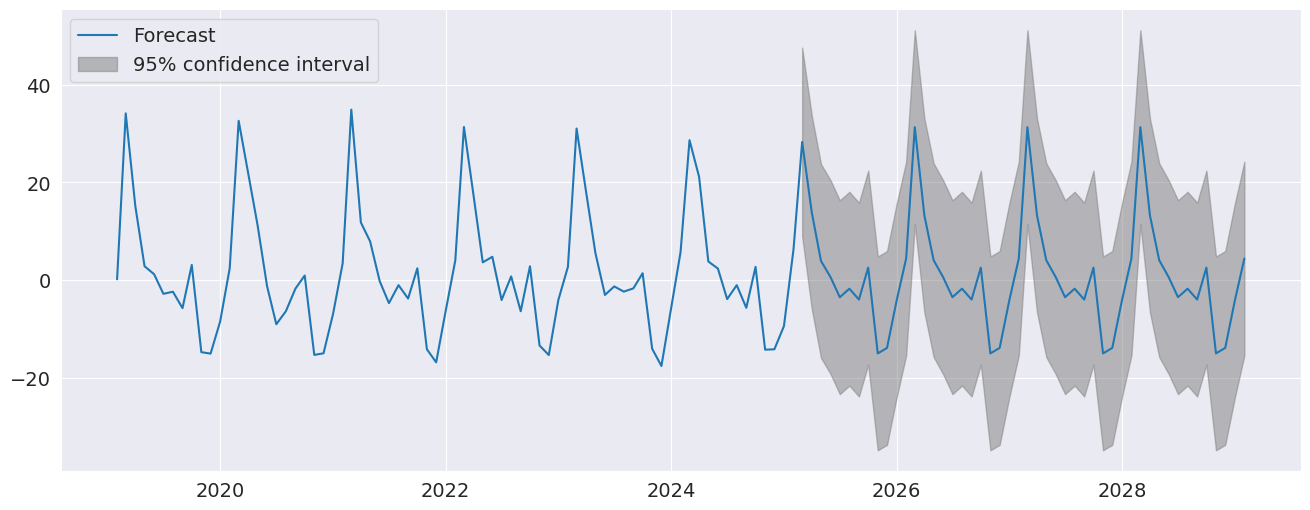

In [10]:
fig = res.plot_predict(720, 840)

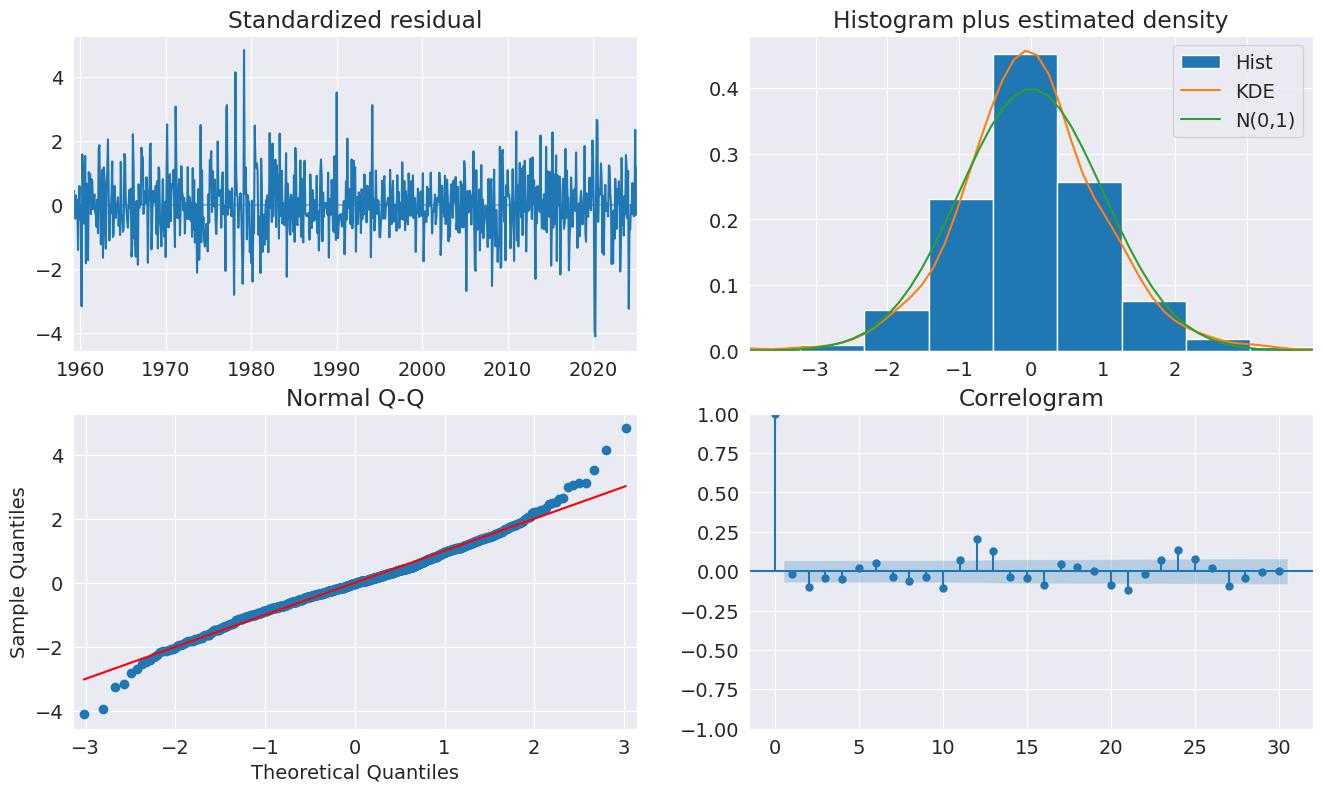

In [11]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(lags=30, fig=fig)

## Seasonal Dynamics

While `AutoReg` does not directly support Seasonal components since it uses OLS to estimate parameters, it is possible to capture seasonal dynamics using an over-parametrized Seasonal AR that does not impose the restrictions in the Seasonal AR. 

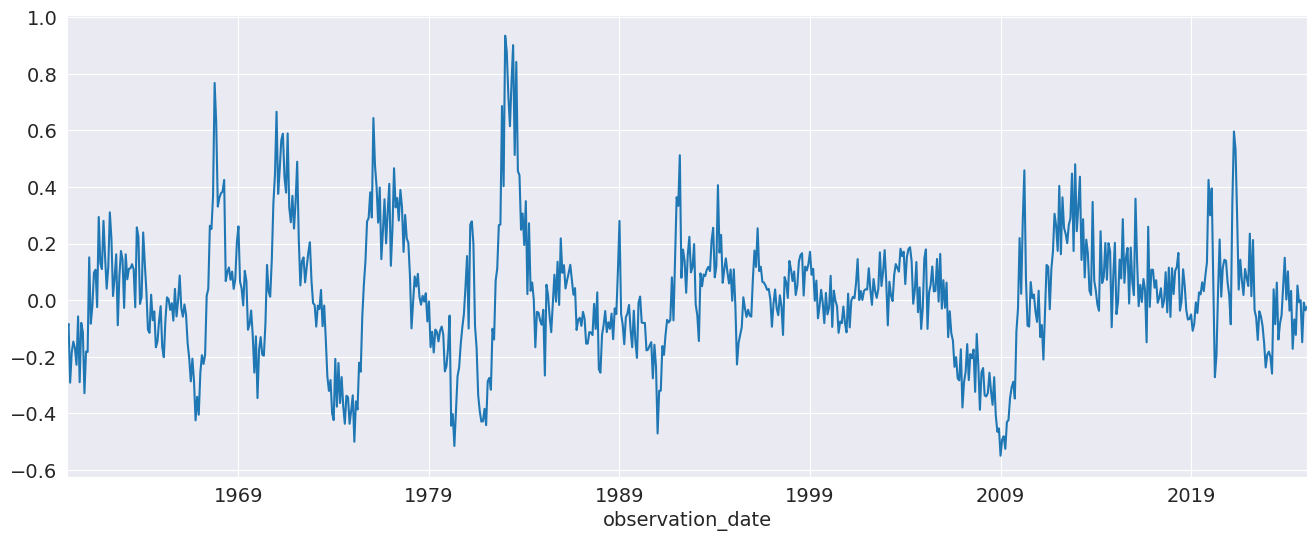

In [12]:
yoy_housing = housing_data.HOUSTNSA.pct_change(12).resample("MS").last().dropna()
_, ax = plt.subplots()
ax = yoy_housing.plot(ax=ax)

We start by selecting a model using the simple method that only chooses the maximum lag.  All lower lags are automatically included. The maximum lag to check is set to 13 since this allows the model to next a Seasonal AR that has both a short-run AR(1) component and a Seasonal AR(1) component, so that

$$ (1-\phi_s L^{12})(1-\phi_1 L)y_t = \epsilon_t $$
which becomes
$$ y_t = \phi_1 y_{t-1} +\phi_s Y_{t-12} - \phi_1\phi_s Y_{t-13} + \epsilon_t $$

when expanded. `AutoReg` does not enforce the structure, but can estimate the nesting model 

$$ y_t = \phi_1 y_{t-1} +\phi_{12} Y_{t-12} - \phi_{13} Y_{t-13} + \epsilon_t. $$

We see that all 13 lags are selected.

In [13]:
sel = ar_select_order(yoy_housing, 13, old_names=False)
sel.ar_lags

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

It seems unlikely that all 13 lags are required.  We can set `glob=True` to search all $2^{13}$ models that include up to 13 lags.

Here we see that the first three are selected, as is the 7th, and finally the 12th and 13th are selected.  This is superficially similar to the structure described above.

After fitting the model, we take a look at the diagnostic plots that indicate that this specification appears to be adequate to capture the dynamics in the data.

In [14]:
sel = ar_select_order(yoy_housing, 13, glob=True, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  782
Model:             Restr. AutoReg(13)   Log Likelihood                 621.088
Method:               Conditional MLE   S.D. of innovations              0.108
Date:                Fri, 12 Sep 2025   AIC                          -1228.177
Time:                        17:42:15   BIC                          -1195.661
Sample:                    02-01-1961   HQIC                         -1215.663
                         - 02-01-2025                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0039      0.004      0.984      0.325      -0.004       0.012
HOUSTNSA.L1      0.5995      0.034     17.831      0.000       0.534       0.665
HOUSTNSA.L2      0.2102      0.036      5.76

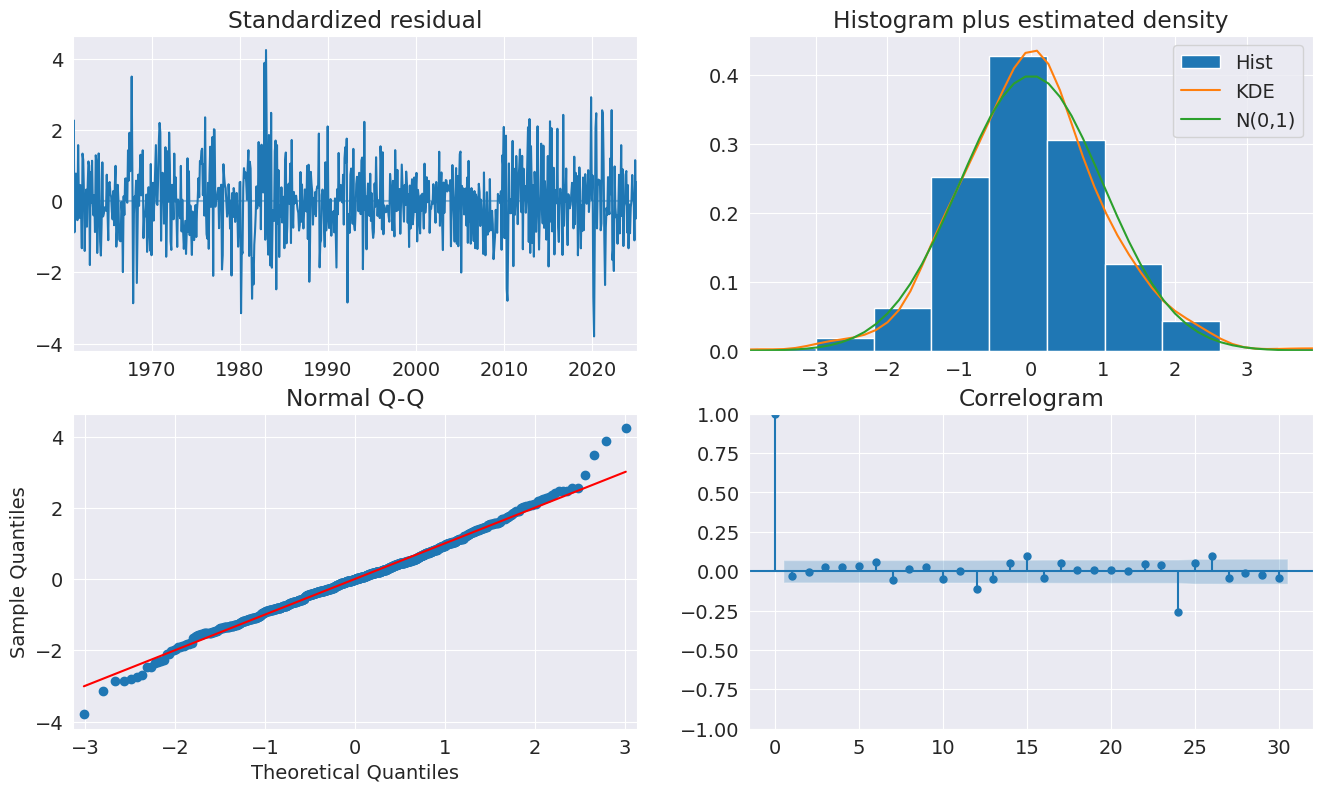

In [15]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

We can also include seasonal dummies.  These are all insignificant since the model is using year-over-year changes.

In [16]:
sel = ar_select_order(yoy_housing, 13, glob=True, seasonal=True, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                               AutoReg Model Results                                
Dep. Variable:                     HOUSTNSA   No. Observations:                  782
Model:             Restr. Seas. AutoReg(13)   Log Likelihood                 622.608
Method:                     Conditional MLE   S.D. of innovations              0.108
Date:                      Fri, 12 Sep 2025   AIC                          -1209.215
Time:                              17:49:12   BIC                          -1125.604
Sample:                          02-01-1961   HQIC                         -1177.036
                               - 02-01-2025                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0120      0.013      0.889      0.374      -0.014       0.038
s(2,12)         -0.0066      0.019     -0.349      0.727      -0.044       0.

## Industrial Production

We will use the industrial production index data to examine forecasting.

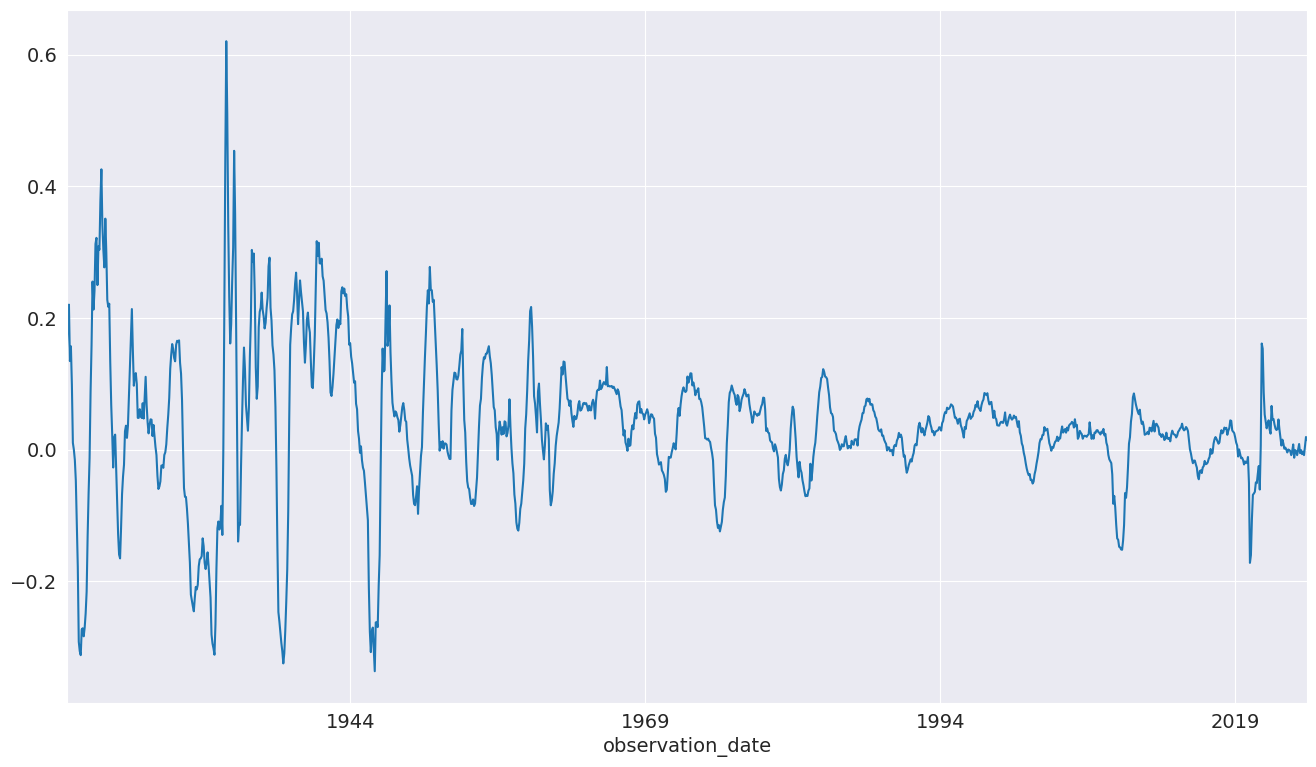

In [17]:
indpro_loc = "https://raw.githubusercontent.com/statsmodels/smdatasets/refs/heads/main/data/autoregressions/INDPRO.csv"
indpro_data = pd.read_csv(
    indpro_loc,
    index_col=0,
    parse_dates=True,
)
ind_prod = indpro_data.INDPRO.pct_change(12).dropna().asfreq("MS")
_, ax = plt.subplots(figsize=(16, 9))
_ = ind_prod.plot(ax=ax)

We will start by selecting a model using up to 12 lags.  An AR(13) minimizes the BIC criteria even though many coefficients are insignificant.

In [18]:
sel = ar_select_order(ind_prod, 13, "bic", old_names=False)
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                 INDPRO   No. Observations:                 1262
Model:                    AutoReg(13)   Log Likelihood                2994.351
Method:               Conditional MLE   S.D. of innovations              0.022
Date:                Fri, 12 Sep 2025   AIC                          -5958.703
Time:                        17:49:13   BIC                          -5881.751
Sample:                    02-01-1921   HQIC                         -5929.773
                         - 02-01-2025                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      3.216      0.001       0.001       0.004
INDPRO.L1      1.3715      0.026     52.595      0.000       1.320       1.423
INDPRO.L2     -0.4501      0.045     -9.965      0.0

We can also use a global search which allows longer lags to enter if needed without requiring the shorter lags. Here we see many lags dropped. The model indicates there may be some seasonality in the data. 

In [19]:
sel = ar_select_order(ind_prod, 13, "bic", glob=True, old_names=False)
sel.ar_lags
res_glob = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                 INDPRO   No. Observations:                 1262
Model:                    AutoReg(13)   Log Likelihood                2994.351
Method:               Conditional MLE   S.D. of innovations              0.022
Date:                Fri, 12 Sep 2025   AIC                          -5958.703
Time:                        17:49:29   BIC                          -5881.751
Sample:                    02-01-1921   HQIC                         -5929.773
                         - 02-01-2025                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      3.216      0.001       0.001       0.004
INDPRO.L1      1.3715      0.026     52.595      0.000       1.320       1.423
INDPRO.L2     -0.4501      0.045     -9.965      0.0

`plot_predict` can be used to produce forecast plots along with confidence intervals. Here we produce forecasts starting at the last observation and continuing for 18 months.

In [20]:
ind_prod.shape

(1262,)

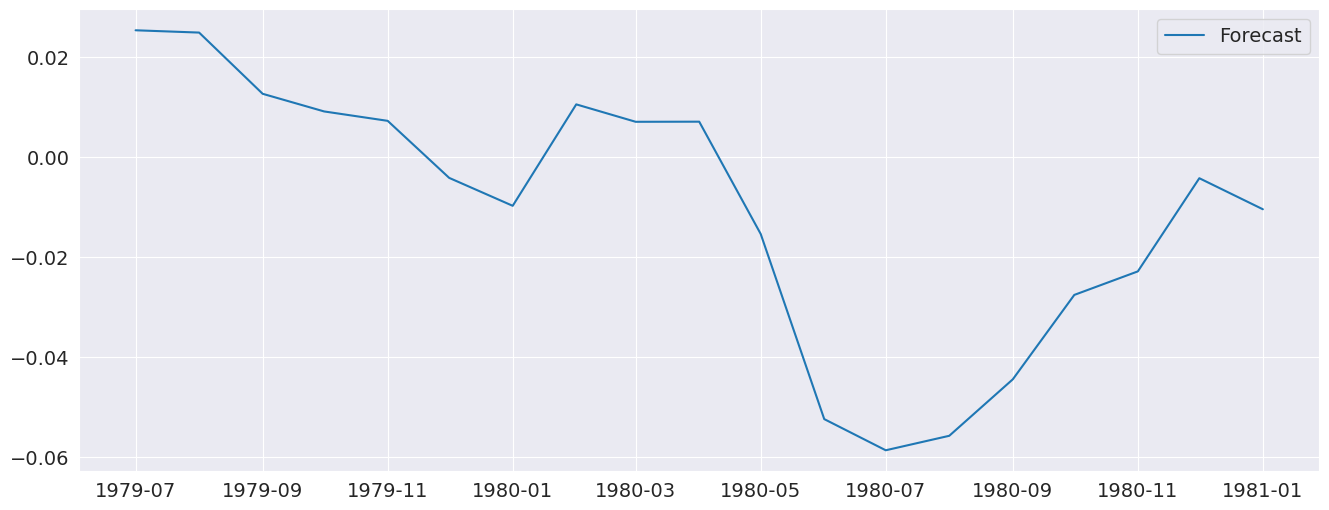

In [21]:
fig = res_glob.plot_predict(start=714, end=732)

The forecasts from the full model and the restricted model are very similar. I also include an AR(5) which has very different dynamics

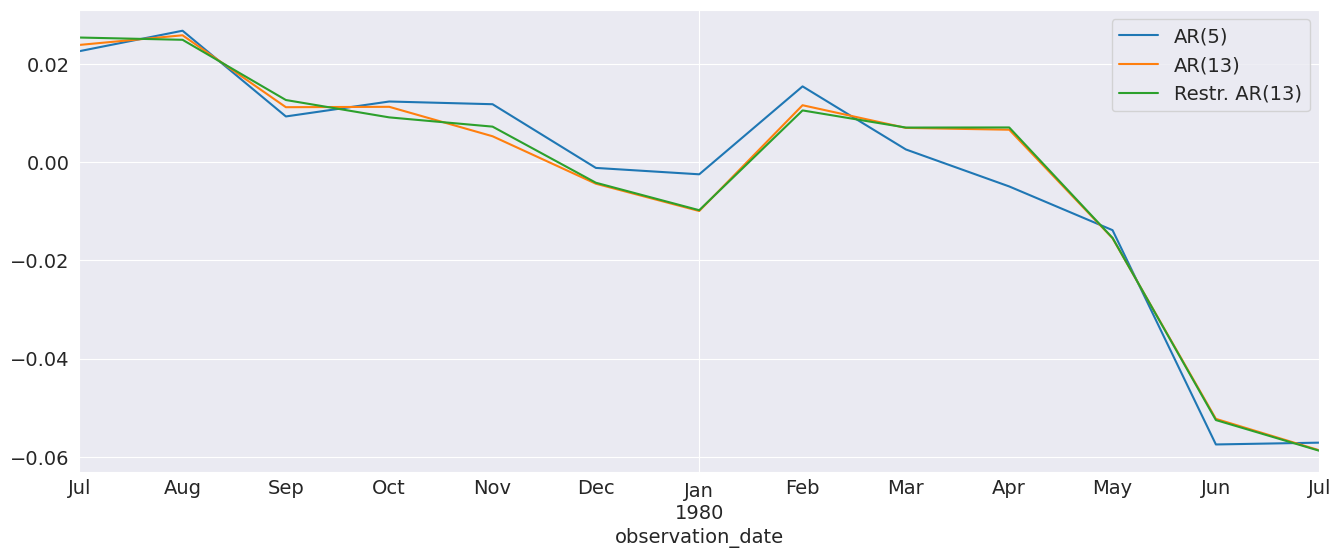

In [22]:
res_ar5 = AutoReg(ind_prod, 5, old_names=False).fit()
predictions = pd.DataFrame(
    {
        "AR(5)": res_ar5.predict(start=714, end=726),
        "AR(13)": res.predict(start=714, end=726),
        "Restr. AR(13)": res_glob.predict(start=714, end=726),
    }
)
_, ax = plt.subplots()
ax = predictions.plot(ax=ax)

The diagnostics indicate the model captures most of the the dynamics in the data. The ACF shows a patters at the seasonal frequency and so a more complete seasonal model (`SARIMAX`) may be needed.

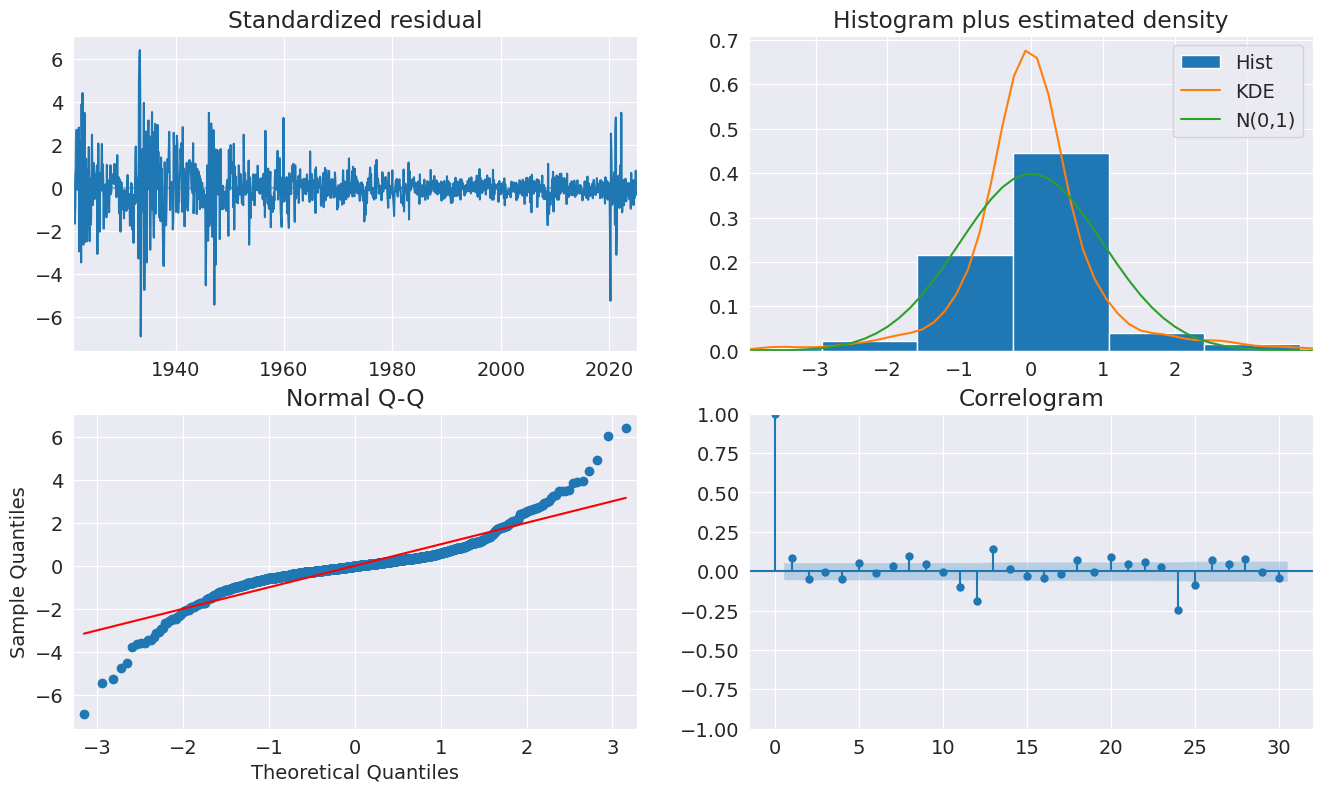

In [23]:
fig = plt.figure(figsize=(16, 9))
fig = res_glob.plot_diagnostics(fig=fig, lags=30)

# Forecasting

Forecasts are produced using the `predict` method from a results instance. The default produces static forecasts which are one-step forecasts. Producing multi-step forecasts requires using `dynamic=True`.  

In this next cell, we produce 12-step-heard forecasts for the final 24 periods in the sample.  This requires a loop.

**Note**: These are technically in-sample since the data we are forecasting was used to estimate parameters. Producing OOS forecasts requires two models.  The first must exclude the OOS period.  The second uses the `predict` method from the full-sample model with the parameters from the shorter sample model that excluded the OOS period.

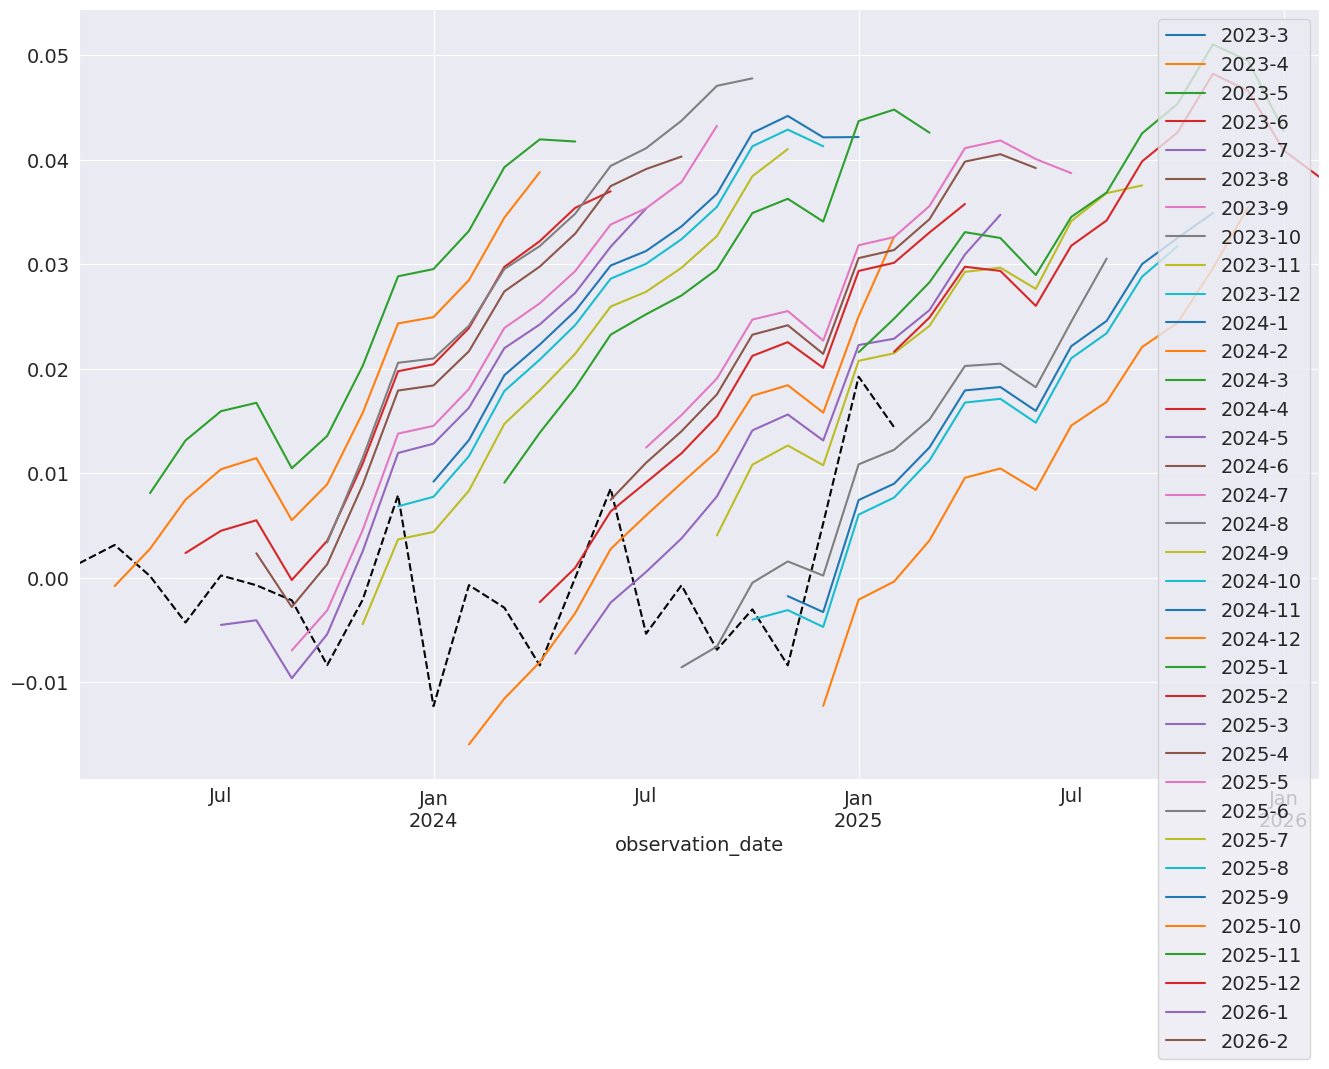

In [24]:
import numpy as np

start = ind_prod.index[-24]
forecast_index = pd.date_range(start, freq=ind_prod.index.freq, periods=36)
cols = ["-".join(str(val) for val in (idx.year, idx.month)) for idx in forecast_index]
forecasts = pd.DataFrame(index=forecast_index, columns=cols)
for i in range(1, 24):
    fcast = res_glob.predict(
        start=forecast_index[i], end=forecast_index[i + 12], dynamic=True
    )
    forecasts.loc[fcast.index, cols[i]] = fcast
_, ax = plt.subplots(figsize=(16, 10))
ind_prod.iloc[-24:].plot(ax=ax, color="black", linestyle="--")
ax = forecasts.plot(ax=ax)

## Comparing to SARIMAX

`SARIMAX` is an implementation of a Seasonal Autoregressive Integrated Moving Average with eXogenous regressors model.  It supports:

* Specification of seasonal and nonseasonal AR and MA components
* Inclusion of Exogenous variables
* Full maximum-likelihood estimation using the Kalman Filter

This model is more feature rich than `AutoReg`. Unlike `SARIMAX`, `AutoReg` estimates parameters using OLS.  This is faster and the problem is globally convex, and so there are no issues with local minima. The closed-form estimator and its performance are the key advantages of `AutoReg` over `SARIMAX` when comparing AR(P) models.  `AutoReg` also support seasonal dummies, which can be used with `SARIMAX` if the user includes them as exogenous regressors. 

In [25]:
from statsmodels.tsa.api import SARIMAX

sarimax_mod = SARIMAX(ind_prod, order=((1, 2, 7, 12, 13), 0, 0), trend="c")
sarimax_res = sarimax_mod.fit()
print(sarimax_res.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               INDPRO   No. Observations:                 1262
Model:             SARIMAX([1, 2, 7, 12, 13], 0, 0)   Log Likelihood                2994.915
Date:                              Fri, 12 Sep 2025   AIC                          -5975.830
Time:                                      17:49:34   BIC                          -5939.847
Sample:                                  01-01-1920   HQIC                         -5962.309
                                       - 02-01-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0020      0.001      2.789      0.005       0.001       0.003
ar.L1          1.35

In [26]:
sarimax_params = sarimax_res.params.iloc[:-1].copy()
sarimax_params.index = res_glob.params.index
params = pd.concat([res_glob.params, sarimax_params], axis=1, sort=False)
params.columns = ["AutoReg", "SARIMAX"]
params

AutoReg   SARIMAX
const       0.002252  0.001954
INDPRO.L1   1.355149  1.354845
INDPRO.L2  -0.396530 -0.391420
INDPRO.L7   0.048080  0.043527
INDPRO.L12 -0.447984 -0.461550
INDPRO.L13  0.381658  0.396978

## Custom Deterministic Processes

The `deterministic` parameter allows a custom `DeterministicProcess` to be used. This allows for more complex deterministic terms to be constructed, for example one that includes seasonal components with two periods, or, as the next example shows, one that uses a Fourier series rather than seasonal dummies.

In [27]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(housing.index, constant=True, period=12, fourier=2)
mod = AutoReg(housing, 2, trend="n", seasonal=False, deterministic=dp)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  793
Model:                     AutoReg(2)   Log Likelihood               -2992.123
Method:               Conditional MLE   S.D. of innovations             10.631
Date:                Fri, 12 Sep 2025   AIC                           6000.246
Time:                        17:49:34   BIC                           6037.633
Sample:                    04-01-1959   HQIC                          6014.616
                         - 02-01-2025                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.6409      0.383      4.282      0.000       0.890       2.392
sin(1,12)      15.0006      0.804     18.648      0.000      13.424      16.577
cos(1,12)       4.9139      0.571      8.613    

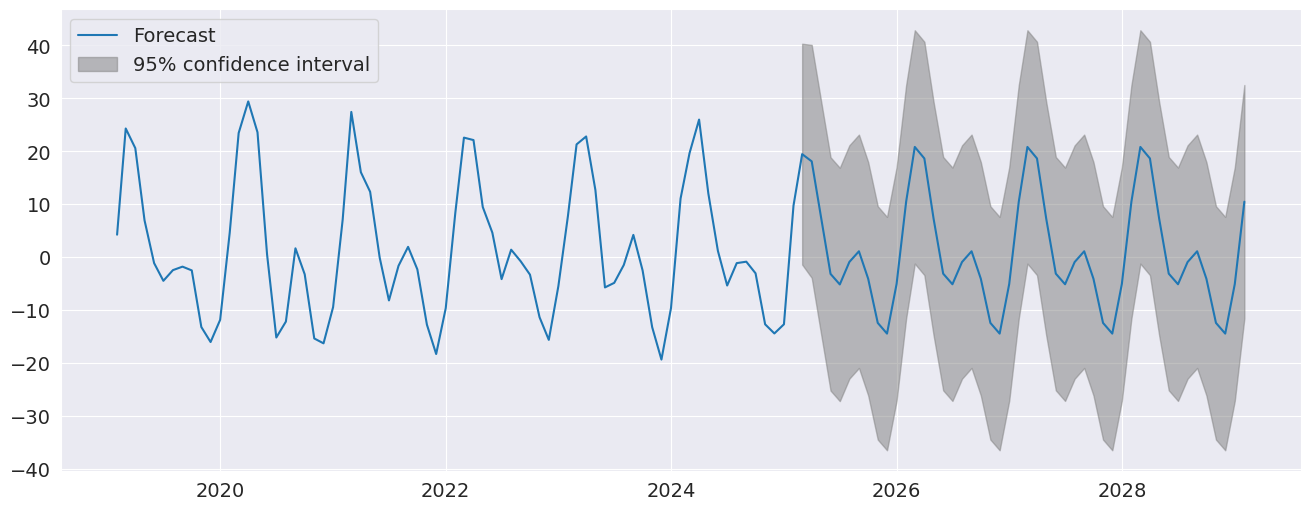

In [28]:
fig = res.plot_predict(720, 840)